In [1]:
import pandas as pd
import time
from datetime import datetime, date, time, timedelta
import io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os 
import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt

In [37]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [582]:
outPath = r'F:\DriversFireProject\FinalCSV_Info'
df = pd.read_csv(os.path.join(outPath, 'FireInfoVar_Final.csv'), index_col=0)

In [595]:
spreadFile = df.drop_duplicates()
spreadFile = spreadFile.dropna()
spreadFile = spreadFile[spreadFile['Area (ha)'] != 0]
# how many fires? 
print("Total Fires:" ,len(spreadFile.groupby(['Fire', 'Year'])))
# how many total days? 
print("Total Days:", len(spreadFile))

Total Fires: 241
Total Days: 1395


In [596]:
spreadFile.groupby(['FID_ca_eco'])['JulianDay'].count()

FID_ca_eco
3      66
4     379
5     193
7     681
8      44
11     32
Name: JulianDay, dtype: int64

In [585]:
spreadFile = spreadFile[(spreadFile['FID_ca_eco'] == 3) ]#| (spreadFile['FID_ca_eco'] == 11)]
spreadFile

,JulianDay,Area (ha),DIR_WA,DIR_MaxDist,DIST_MEDSTD,Magnitude (max),Magnitude (median),Magnitude (stdv),Magnitude (lowerQ),Magnitude (upperQ),...,windfromdirection,windfromdirection_STD,windspeed,windspeed_STD,BARREN,DEVELOPED,AGRICULTURE,shortHeight,medShortHeight,medHeight
56,249,870.053,181.702,217.120,1.687 ± 0.458,2.865,1.687,0.458,1.509,1.977,...,128.140025,13.497112,2.581552,0.029765,0.100176,0.000000,0.0,0.582653,0.001757,0.000000
57,250,1503.828,131.727,149.617,2.336 ± 1.046,4.157,2.336,1.046,1.374,3.078,...,194.311310,1.100519,2.725695,0.011739,0.045340,0.000000,0.0,0.604636,0.041327,0.000000
58,251,184.785,198.901,182.420,0.479 ± 0.252,0.927,0.479,0.252,0.280,0.771,...,23.828684,10.381200,3.278988,0.011596,0.084267,0.006332,0.0,0.527034,0.002435,0.000000
59,252,154.726,193.853,206.573,0.504 ± 0.404,1.479,0.504,0.404,0.299,1.017,...,28.530441,0.000000,3.284240,0.000000,0.092379,0.000000,0.0,0.544457,0.000000,0.000000
60,219,386.721,168.293,16.756,1.159 ± 0.342,1.674,1.159,0.342,0.905,1.506,...,185.449337,12.877174,2.971020,0.008604,0.004422,0.000000,0.0,0.981848,0.000000,0.000233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,212,577.257,285.244,343.164,1.274 ± 0.745,2.630,1.274,0.745,0.779,2.134,...,256.026962,1.095509,2.974730,0.017312,0.001559,0.000000,0.0,0.000312,0.034924,0.058466
1382,248,636.949,165.997,207.932,1.497 ± 0.717,2.875,1.497,0.717,1.227,2.381,...,117.614571,6.498990,2.900000,0.000000,0.002968,0.000000,0.0,0.933861,0.052996,0.011023
1383,249,805.096,230.568,339.602,1.347 ± 0.795,2.845,1.347,0.795,0.708,2.077,...,177.000000,0.000000,2.600000,0.000000,0.011741,0.000000,0.0,0.914794,0.049089,0.025271
1390,240,520.949,164.571,25.346,1.333 ± 0.289,2.010,1.333,0.289,1.079,1.554,...,142.000000,0.000000,4.384094,0.036573,0.229120,0.010548,0.0,0.302092,0.278229,0.041674


In [597]:
spreadFile.columns

# 'DIR_WA', 'DIR_MaxDist', 'DIST_MEDSTD', 'Magnitude (max)','Magnitude (stdv)','Magnitude (lowerQ)', 
responsVar = ['Area (ha)', 'Magnitude (median)', 'Magnitude (max)', 'Magnitude (upperQ)', 'Fire', 'Year', 'EcoRegion',
       'FID_ca_eco']

indVar = ['Aspect',  'CBD', 'CONIFER','CONIFER_HA', 'Curvature', 'DEM',  'EVI',
        'EXOTIC_HER', 'FBFM1', 'FBFM10', 'FBFM11', 'FBFM12', 'FBFM2', 'Slope_STD',
        'FBFM3', 'FBFM4', 'FBFM5', 'FBFM6', 'FBFM7', 'FBFM8', 'FBFM9', 'FFWI',
        'GRASSLAND', 'HARDWOOD', 'MaxNDVI',  'NDMI','NDMIDelta',  'NDVI',  'POP','AGRICULTURE',
        'RIPARIAN', 'RoadDensity', 'SHRUBLAND','SPARSELY_V', 'Slope',  'VALUE_108', 'VALUE_109',
        'VALUE_110', 'VALUE_111', 'VALUE_112', 'burningindexg','deadfuelmoisture100hr',
        'energyreleasecomponent','maximumairtemperature','meanvaporpressuredeficit','minimumrelativehumidity',
        'planCurvature', 'profileCurvature', 'referenceevapotranspirationgrass','windfromdirection','windspeed',  
        'BARREN','DEVELOPED', 'shortHeight', 'medShortHeight','medHeight']

deleteVars = ['Aspect_STD',  'CBD_STD', 'Curvature_STD', 'DEM_STD','EVI_STD', 'URBAN', 
             'FFWI_STD', 'MaxNDVI_STD',  'NDMIDelta_STD', 'NDMI_STD', 'NDVI_STD', 'POP_STD',
             'RoadDensity_STD',  'burningindexg_STD', 'deadfuelmoisture100hr_STD','energyreleasecomponent_STD',
             'maximumairtemperature_STD', 'meanvaporpressuredeficit_STD', 'minimumrelativehumidity_STD',
             'planCurvature_STD', 'profileCurvature_STD','referenceevapotranspirationgrass_STD', 'windspeed_STD',
             'windfromdirection_STD', 'WATER']

In [598]:
spreadFile = spreadFile.drop(columns = deleteVars)
spreadFile = spreadFile[spreadFile['Area (ha)'] != 0]
responsDF = spreadFile[responsVar]
indDF = spreadFile[indVar]

In [599]:
responsDF = responsDF.rename(columns={"Area (ha)": "Area", 'Magnitude (upperQ)': "upperQMag", 
                                      'Magnitude (median)' : 'medMag', 'Magnitude (max)' : 'maxMag'})
responsDF.head()

,Area,medMag,maxMag,upperQMag,Fire,Year,EcoRegion,FID_ca_eco
0,542.397,1.319,1.730,1.503,Bagleycomplex,2012,Klamath Mountains,7
1,831.816,0.650,1.204,0.770,Bagleycomplex,2012,Klamath Mountains,7
2,1025.933,0.581,1.247,0.754,Bagleycomplex,2012,Klamath Mountains,7
3,1151.104,0.475,1.048,0.661,Bagleycomplex,2012,Klamath Mountains,7
4,1351.212,0.612,1.196,0.744,Bagleycomplex,2012,Klamath Mountains,7


In [600]:
indDF.head()

,Aspect,CBD,CONIFER,CONIFER_HA,Curvature,DEM,EVI,EXOTIC_HER,FBFM1,FBFM10,...,planCurvature,profileCurvature,referenceevapotranspirationgrass,windfromdirection,windspeed,BARREN,DEVELOPED,shortHeight,medShortHeight,medHeight
0,-0.972924,6.366230,0.722176,0.003483,0.019701,997.449328,0.557216,0.001327,0.153425,0.289932,...,0.012679,-0.007022,7.229238,235.797951,2.863787,0.000166,0.000166,0.154752,0.001161,0.0
1,-0.999480,5.283086,0.671356,0.008224,0.024745,921.621902,0.506276,0.010930,0.209176,0.236771,...,0.015186,-0.009367,7.197903,232.615572,2.869086,0.001299,0.001082,0.214371,0.000216,0.0
2,-0.982792,6.033987,0.788639,0.005172,-0.016101,869.462064,0.513762,0.003244,0.085912,0.264750,...,0.005921,0.021726,7.679669,332.381531,3.205285,0.000438,0.000175,0.071798,0.000000,0.0
3,-0.998320,5.641812,0.617081,0.004614,-0.010207,871.314299,0.518022,0.002894,0.169717,0.233067,...,0.016377,0.026287,7.724344,194.267395,3.455905,0.000156,0.000235,0.156030,0.000235,0.0
4,-0.996737,5.668325,0.650456,0.007061,-0.001075,842.663349,0.561268,0.000933,0.150756,0.233029,...,0.039793,0.040730,7.765856,194.267395,3.475116,0.000466,0.000000,0.136766,0.000200,0.0


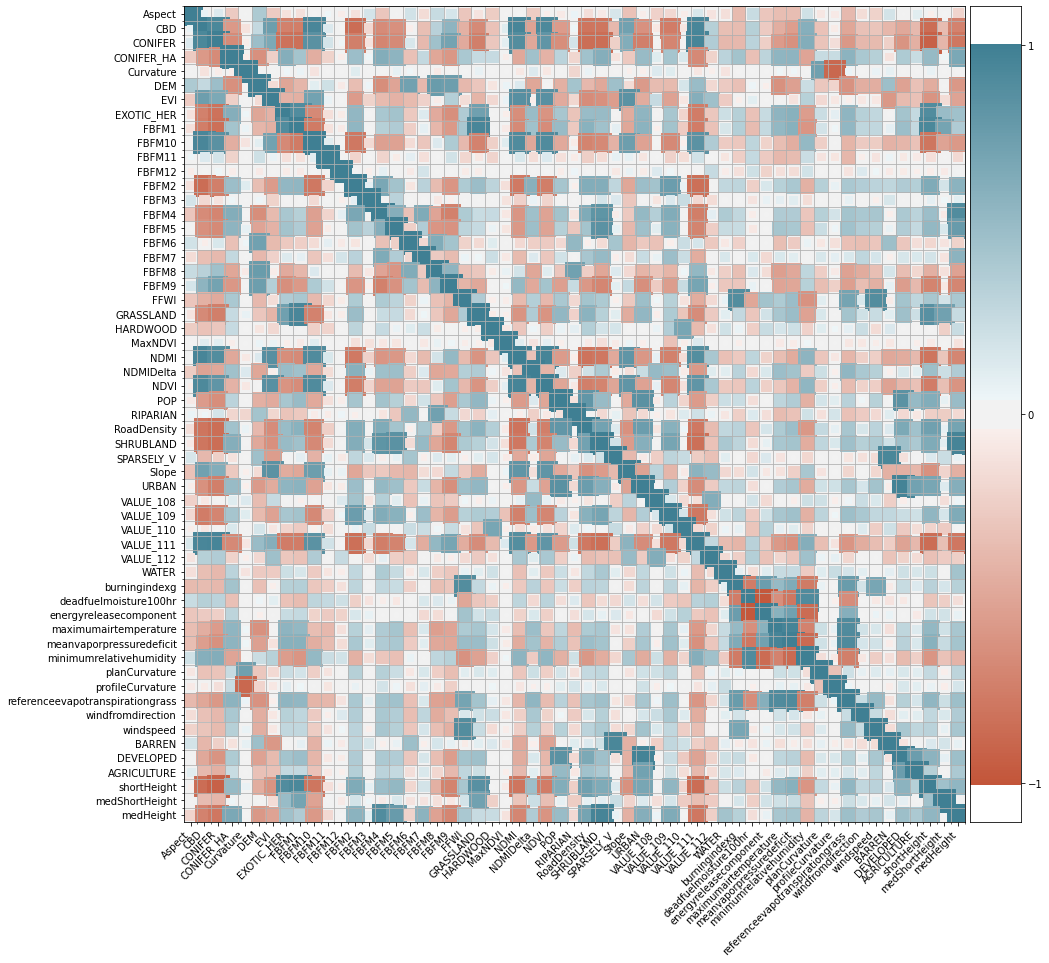

In [143]:
corr_sample = indDF.corr()
plt.figure(figsize=(15, 15))
corrplot(corr_sample.corr())

In [422]:
result = pd.concat([responsDF['Area'], indDF], axis=1, sort=False)
result = result._get_numeric_data()

In [145]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = "+".join(indDF.columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('Area ~' + features, result, return_type='dataframe')

In [424]:
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["features"] = X.columns
# vif.round(1).sort_values( ['VIF Factor'], ascending = False)

In [720]:
# from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

columns = indDF.columns

sc = StandardScaler()

X = sc.fit_transform(indDF.values)
Y = np.log(responsDF['Area'].values)

In [721]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.40, random_state=42)

# Random Forest 
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 0)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=0)
regressor.fit(X_train,Y_train)

rf_predictions = regressor.predict(X_test)
errors = np.square(abs((rf_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: " , regressor.score(X_test,Y_test))

absolute error:  1.837390238942683
Test Score:  0.7320356879936084


In [568]:
## SVM 
from sklearn.svm import SVR
svr_regressor = SVR(kernel='rbf', gamma ='auto')
svr_regressor.fit(X_train,Y_train)
svr_predictions = svr_regressor.predict(X_test)
errors = np.square(abs((svr_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: ", svr_regressor.score(X_test,Y_test))

absolute error:  1.5920240526727496
Test Score:  0.5172401654921255


In [569]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
CART_regressor=tree.DecisionTreeRegressor()
CART_regressor.fit(X_train, Y_train)
cart_predictions = CART_regressor.predict(X_test)
errors = np.square(abs((cart_predictions) - Y_test))
print("absolute error: " , np.exp(np.mean(errors)))
print("Test Score: ", CART_regressor.score(X_test,Y_test))

absolute error:  2.1423011431471246
Test Score:  0.20903133663555384


In [593]:
# k-fold cross validation 
RF_scores = []
SVM_scores = []
CART_scores = [] 

## SVM 
svr_regressor = SVR(kernel='rbf', gamma='auto')
## RF 
RF_regressor = RandomForestRegressor(n_estimators = 100)
## CART 
CART_regressor = DecisionTreeRegressor()

cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index],Y[train_index], Y[test_index]
    RF_regressor.fit(X_train,Y_train)
    rf_predictions = regressor.predict(X_test)
    rf_errors = abs((rf_predictions) - Y_test)
    
    CART_regressor.fit(X_train,Y_train)
    cart_predictions = CART_regressor.predict(X_test)
    cart_errors = abs((cart_predictions) - Y_test)
    
    svr_regressor.fit(X_train,Y_train)
    svr_predictions = svr_regressor.predict(X_test)
    svr_errors = abs((svr_predictions) - Y_test)
    
    SVM_scores.append((svr_regressor.score(X_test, Y_test), np.mean(svr_errors)))
    RF_scores.append((RF_regressor.score(X_test, Y_test), np.mean(rf_errors)))
    CART_scores.append((CART_regressor.score(X_test, Y_test), np.mean(cart_errors)))

In [594]:
print("RF", np.mean([i[0] for i in RF_scores]), np.exp(np.mean([i[1] for i in RF_scores])))
print("SVM", np.mean([i[0] for i in SVM_scores]), np.exp(np.mean([i[1] for i in SVM_scores])) )
print("CART",np.mean([i[0] for i in CART_scores]), np.exp(np.mean([i[1] for i in CART_scores])))

RF 0.3198265169915272 1.7654308063333655
SVM -0.26798164974492716 3.0526386494849613
CART -1.1123009365145342 3.5000247256497192


In [609]:
def plot_feature_importances_diabetes(model, indDF):
    
    sns.set(font_scale=0.8)
    feature_importances_ALL = pd.DataFrame()
    feature_importances_ALL['Gini feature importance'] = model.feature_importances_
    feature_importances_ALL['Variables'] = indDF.columns
    feature_importances_ALL = feature_importances_ALL.sort_values(by='Gini feature importance', ascending=False)

    sns.set_color_codes("pastel")
    ax = sns.barplot(x="Gini feature importance", y="Variables", data=feature_importances_ALL[:20],color="b")

    ax.set(xlim=(0, 0.3))

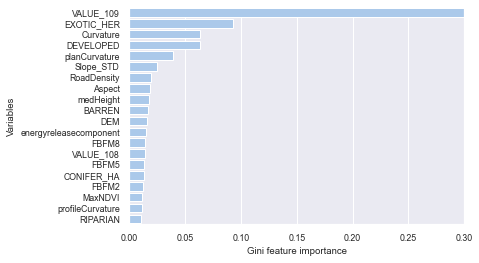

In [621]:
sns.set(style="whitegrid")
plot_feature_importances_diabetes(regressor, indDF)

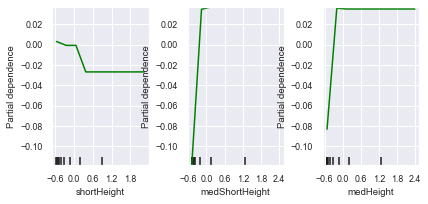

In [767]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
my_model = GradientBoostingRegressor()
# fit the model as usual
my_model.fit(X_train,Y_train)
# Here we make the plot
my_plots = plot_partial_dependence(my_model,       
                                   features=[53, 54, 55], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=['Aspect', 'CBD', 'CONIFER', 'CONIFER_HA', 'Curvature', 'DEM', 'EVI',
       'EXOTIC_HER', 'FBFM1', 'FBFM10', 'FBFM11', 'FBFM12', 'FBFM2',
       'Slope_STD', 'FBFM3', 'FBFM4', 'FBFM5', 'FBFM6', 'FBFM7', 'FBFM8',
       'FBFM9', 'FFWI', 'GRASSLAND', 'HARDWOOD', 'MaxNDVI', 'NDMI',
       'NDMIDelta', 'NDVI', 'POP', 'AGRICULTURE', 'RIPARIAN', 'RoadDensity',
       'SHRUBLAND', 'SPARSELY_V', 'Slope', 'VALUE_108', 'VALUE_109',
       'VALUE_110', 'VALUE_111', 'VALUE_112', 'burningindexg',
       'deadfuelmoisture100hr', 'energyreleasecomponent',
       'maximumairtemperature', 'meanvaporpressuredeficit',
       'minimumrelativehumidity', 'planCurvature', 'profileCurvature',
       'referenceevapotranspirationgrass', 'windfromdirection', 'windspeed',
       'BARREN', 'DEVELOPED', 'shortHeight', 'medShortHeight', 'medHeight'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

In [766]:
cols = ['shortHeight', 'medShortHeight', 'medHeight']
[indDF.columns.get_loc(c) for c in cols if c in indDF]

[53, 54, 55]